In [36]:
import pandas as pd
import os
import glob

In [37]:
currentFile = ''
path = 'lda_clustered_json/'+currentFile
frames = []
pd.read_json(currentFile, orient='index')

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


In [38]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")
processed_articles = df['maintext_ready']

Amount of articles: 829


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.5)  
tfidf = tfidfconverter.fit_transform(processed_articles)
print(tfidf)

  (0, 1558)	0.05827356802598794
  (0, 247)	0.04372634889765276
  (0, 610)	0.044875447249760475
  (0, 1586)	0.05333781756080155
  (0, 418)	0.04028257657927815
  (0, 1444)	0.047887862900793075
  (0, 405)	0.042046926730557106
  (0, 625)	0.05891760457049562
  (0, 8)	0.032749492140269704
  (0, 1229)	0.032799447189406736
  (0, 1165)	0.05109316486548987
  (0, 1909)	0.05166447419001581
  (0, 1362)	0.053498081579257784
  (0, 1711)	0.046104313751294396
  (0, 1772)	0.045685144994614915
  (0, 257)	0.055725338346671593
  (0, 778)	0.051234273605522504
  (0, 216)	0.06393945446934292
  (0, 1580)	0.056662543968227896
  (0, 706)	0.037465691443657606
  (0, 1478)	0.06100343061216464
  (0, 779)	0.035495990756956815
  (0, 1635)	0.05225483062923191
  (0, 244)	0.059585950045623365
  (0, 1590)	0.04860589584250154
  :	:
  (828, 750)	0.04593386399536199
  (828, 748)	0.04185797215772493
  (828, 1835)	0.0773341857362031
  (828, 98)	0.03498316596884138
  (828, 62)	0.03164393566097814
  (828, 927)	0.0309650976480472

In [42]:
from sklearn.metrics.pairwise import cosine_distances

cosine_similarity = cosine_distances(tfidf)
cosine_similarity

array([[0.        , 0.99702862, 0.91180015, ..., 0.81836882, 0.91778002,
        0.9708658 ],
       [0.99702862, 0.        , 0.96961797, ..., 0.98453027, 0.9917592 ,
        0.99814148],
       [0.91180015, 0.96961797, 0.        , ..., 0.93482151, 0.91612201,
        0.99047824],
       ...,
       [0.81836882, 0.98453027, 0.93482151, ..., 0.        , 0.90994717,
        0.97893931],
       [0.91778002, 0.9917592 , 0.91612201, ..., 0.90994717, 0.        ,
        0.97967818],
       [0.9708658 , 0.99814148, 0.99047824, ..., 0.97893931, 0.97967818,
        0.        ]])

In [43]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(affinity='precomputed', damping=0.5, random_state=5)
clustering.fit(cosine_similarity)
labels = clustering.labels_
print(labels.dtype)
#cluster_centers = clustering.cluster_centers_
cluster_centers_indices = clustering.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

int64


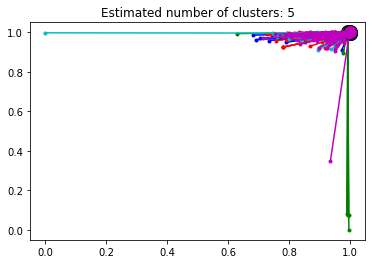

In [44]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cosine_similarity[cluster_centers_indices[k]]
    plt.plot(cosine_similarity[class_members, 0], cosine_similarity[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in cosine_similarity[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [45]:
df['processed_articles'] = processed_articles
df['affpropID'] = clustering.labels_
df.head()

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,processed_articles,affpropID
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,editor note anderson cooper explains why t shi...,3
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,for the latest updates to global public square...,1
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,for the latest updates to global public square...,2
3,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 15:53:08",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,for the latest updates to global public square...,4
4,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 17:20:20",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,for the latest updates to global public square...,4
